Project: Decoding the Digital Rupee: A Predictive Analysis of India's UPI Spending
Course: DA 204o - Data Science in Practice

Team Members:
- Jabin Shalom S (jabinshaloms@iisc.ac.in)
- Suganya H (suganyah@iisc.ac.in)

Dataset: UPI Transactions 2024 Dataset from Kaggle
URL: https://www.kaggle.com/code/skullagos5246/upi-transactions-generator


PART 1: IMPORT REQUIRED LIBRARIES


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor

# Google Drive Download Library
try:
    import gdown
except ImportError:
    print("Installing gdown...")
    import os
    os.system('pip install gdown')
    import gdown

# Interpretability (SHAP)
try:
    import shap
except ImportError:
    print("Installing SHAP...")
    import os
    os.system('pip install shap')
    import shap

import warnings
warnings.filterwarnings('ignore')

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" All libraries imported successfully!")

 All libraries imported successfully!


PART 2: LOAD AND EXPLORE DATA

In [2]:
def load_data(file_path='data/raw/upi_transactions_2024.csv'):
    """
    Loads the dataset. If not found locally, downloads it from the
    provided Google Drive shared link.
    """
    # YOUR SPECIFIC GOOGLE DRIVE ID (Extracted from your link)
    file_id = '1L0rPEjyMMe_KuLikL-ulmMj2s3hzGi8O'
    drive_url = f'https://drive.google.com/uc?id={file_id}'

    # Check if file exists locally
    if os.path.exists(file_path):
        print(f"\n Found local file: {file_path}")
        df = pd.read_csv(file_path)
    else:
        print(f"\n File not found locally. Downloading from Google Drive...")
        try:
            gdown.download(drive_url, file_path, quiet=False)
            print(" Download successful!")
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f" Error downloading file: {e}")
            return None

    print(f"Dataset shape: {df.shape}")
    return df

def explore_data(df):
    """
    Exploratory Data Analysis (Enhanced with Skewness Check)
    """
    print("\n" + "="*50)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*50)

    # Basic information
    print("\n1. Dataset Info:")
    print(f"   - Number of rows: {df.shape[0]:,}")
    print(f"   - Number of columns: {df.shape[1]}")
    print(f"   - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Display first few rows
    print("\n2. First 5 rows:")
    print(df.head())

    # Data types
    print("\n3. Data Types:")
    print(df.dtypes)

    # Missing values
    print("\n4. Missing Values:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("   No missing values found!")

    # Statistical summary
    print("\n5. Statistical Summary:")
    print(df.describe())

    # Check Skewness for Target Variable (Crucial for your Model Accuracy)
    if 'Transaction_Amount' in df.columns:
        skew = df['Transaction_Amount'].skew()
        print(f"\n6. Target Variable Skewness: {skew:.2f}")
        if abs(skew) > 1:
            print("    High skewness detected! Log-transformation will be applied in preprocessing.")

    return df

PART 3: DATA PREPROCESSING

In [3]:
def preprocess_data(df, target_column='amount (INR)'):
    print("\n" + "="*50)
    print("PREPROCESSING (CORRECTED)")
    print("="*50)

    df_proc = df.copy()

    # 1. Drop Identifier/Timestamp columns (Not useful for prediction)
    drop_cols = ['transaction id', 'timestamp']
    existing_drop = [c for c in drop_cols if c in df_proc.columns]
    if existing_drop:
        print(f" Dropping non-predictive columns: {existing_drop}")
        df_proc.drop(columns=existing_drop, inplace=True)

    # 2. Impute Missing Values
    num_cols = df_proc.select_dtypes(include=[np.number]).columns
    cat_cols = df_proc.select_dtypes(include=['object']).columns

    # Fill numeric with median
    for col in num_cols:
        if col != target_column and col in df_proc.columns:
            df_proc[col].fillna(df_proc[col].median(), inplace=True)

    # Fill categorical with mode
    for col in cat_cols:
        df_proc[col].fillna(df_proc[col].mode()[0], inplace=True)

    # 3. Encode Categoricals
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df_proc[col] = le.fit_transform(df_proc[col].astype(str))
        encoders[col] = le

    # 4. Log-Transform Target (Fixes Skewness)
    print(f" Applying Log Transformation to '{target_column}'")

    # Filter extreme outliers (Top 1%)
    q_high = df_proc[target_column].quantile(0.99)
    df_proc = df_proc[df_proc[target_column] <= q_high]

    y = np.log1p(df_proc[target_column]) # Log Transform
    X = df_proc.drop(columns=[target_column]) # Features

    # 5. Split & Scale
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    print(f" Data processed. Training shape: {X_train_scaled.shape}")
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

PART 4: MODEL BUILDING

In [4]:
def build_linear_regression(X_train, y_train):
    """
    Baseline Linear Regression Model
    """
    print("\n" + "="*50)
    print("BASELINE MODEL: LINEAR REGRESSION")
    print("="*50)
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def build_random_forest_tuned(X_train, y_train):
    print("\n" + "="*50)
    print("ADVANCED MODEL: RANDOM FOREST (TUNED)")
    print("="*50)

    # Define parameter grid for tuning
    param_dist = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

    # Random Search
    print("   Running Randomized Search CV (this may take a moment)...")
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=5, # Reduced to 5 for speed, increase to 10 if you have time
        cv=3,
        verbose=1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )

    random_search.fit(X_train, y_train)

    print(f"    Best Parameters: {random_search.best_params_}")
    return random_search.best_estimator_

def build_xgboost_tuned(X_train, y_train):
    print("\n" + "="*50)
    print("ADVANCED MODEL: XGBOOST (GPU ACCELERATED )")
    print("="*50)

    # 1. Define parameters to tune
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'subsample': [0.7, 0.8, 1.0]
    }

    # 2. Configure for GPU
    # 'tree_method="hist"' is the fastest algorithm
    # 'device="cuda"' forces it to use the T4 GPU
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method='hist',
        device='cuda'
    )

    print("   Running Randomized Search CV on GPU...")

    # 3. Run Search
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=5, # Keep this low for speed
        cv=3,
        verbose=1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )

    random_search.fit(X_train, y_train)

    print(f"    Best Parameters: {random_search.best_params_}")
    return random_search.best_estimator_

PART 5: MODEL EVALUATION

In [5]:
# ==========================================
# PART 5: EVALUATION (OPTIMIZED FOR SPEED )
# ==========================================
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\n{'='*50}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*50}")

    # 1. SKIP TRAINING PREDICTION (This was the bottleneck!)
    # We comment this out to save ~10-15 mins of processing time
    # y_train_pred_log = model.predict(X_train)

    # 2. Predict ONLY on Test Data (Fast)
    print("   Predicting on test data...")
    y_test_pred_log = model.predict(X_test)

    # 3. Inverse Transform (Convert Log values back to Original Rupees)
    # We use expm1 to reverse the log1p we did in preprocessing
    y_test_orig = np.expm1(y_test)
    y_test_pred = np.expm1(y_test_pred_log)

    # 4. Calculate Test Metrics
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred))
    mae = mean_absolute_error(y_test_orig, y_test_pred)
    r2 = r2_score(y_test_orig, y_test_pred)

    print(f"\nTesting Performance (Real Scale):")
    print(f"  RMSE: ₹{rmse:.2f}")
    print(f"  MAE:  ₹{mae:.2f}")
    print(f"  R²:   {r2:.4f}")

    # Return dictionary with test metrics only
    return {
        'model_name': model_name,
        'test_rmse': rmse,
        'test_r2': r2
    }

PART 6: FEATURE IMPORTANCE ANALYSIS

In [6]:
def analyze_shap(model, X_train, model_name):
    """
    Use SHAP to explain model predictions
    """
    print(f"\n{'='*50}")
    print(f"SHAP EXPLAINABILITY: {model_name}")
    print(f"{'='*50}")

    # Create explainer
    # Note: Use TreeExplainer for XGB/RF, LinearExplainer for Linear Models
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)

        print("\nGenerating SHAP Summary Plot...")
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()

        print("\nGenerating SHAP Density Plot (Beeswarm)...")
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_train, show=False)
        plt.title(f'SHAP Beeswarm Plot - {model_name}')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not run SHAP analysis: {e}")

PART 7: VISUALIZATION FUNCTIONS

In [7]:
def plot_predictions(y_true, y_pred, model_name):
    """
    Plot actual vs predicted values

    Parameters:
    -----------
    y_true : array
        True values
    y_pred : array
        Predicted values
    model_name : str
        Name of the model
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Transaction Amount')
    plt.ylabel('Predicted Transaction Amount')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, model_name):
    """
    Plot residuals distribution

    Parameters:
    -----------
    y_true : array
        True values
    y_pred : array
        Predicted values
    model_name : str
        Name of the model
    """
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Residual plot
    axes[0].scatter(y_pred, residuals, alpha=0.5)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title(f'Residual Plot - {model_name}')

    # Residual distribution
    axes[1].hist(residuals, bins=50, edgecolor='black')
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Residual Distribution - {model_name}')

    plt.tight_layout()
    plt.show()

In [8]:
# ==========================================
# PART 7B: ADVANCED VISUALIZATIONS (NEW)
# ==========================================
def plot_advanced_visuals(df, y_true, y_pred, model_name):
    """
    Generates professional-grade charts for the report/UI.
    """
    print(f"\n{'='*50}")
    print(f"GENERATING ADVANCED VISUALS: {model_name}")
    print(f"{'='*50}")

    # 1. Actual vs Predicted (The "Accuracy" Plot)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, color='blue')
    # Perfect prediction line
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Spending (₹)')
    plt.ylabel('Predicted Spending (₹)')
    plt.title(f'Accuracy Check: Actual vs Predicted ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Distribution of Spending (The "Reality" Plot)
    plt.figure(figsize=(10, 6))
    sns.histplot(y_true, color="green", label="Actual", kde=True, alpha=0.4)
    sns.histplot(y_pred, color="blue", label="Predicted", kde=True, alpha=0.4)
    plt.title("Distribution of Transaction Amounts: Actual vs Predicted")
    plt.xlabel("Amount (₹)")
    plt.legend()
    plt.show()

    # 3. Merchant Category Boxplot (The "Insight" Plot)
    if 'merchant_category' in df.columns and 'amount (INR)' in df.columns:
        plt.figure(figsize=(12, 6))
        # Filter top 10 categories to keep it readable
        top_cats = df['merchant_category'].value_counts().nlargest(10).index
        df_filtered = df[df['merchant_category'].isin(top_cats)]

        sns.boxplot(data=df_filtered, x='merchant_category', y='amount (INR)', palette='viridis')
        plt.xticks(rotation=45)
        plt.title("Spending Ranges by Merchant Category (Top 10)")
        plt.yscale('log') # Log scale helps visualize data with huge outliers
        plt.ylabel("Amount (₹) - Log Scale")
        plt.show()

PART 8: MAIN WORKFLOW

In [9]:
# ==========================================
# PART 8: MAIN EXECUTION (FINAL VERSION)
# ==========================================
def main():
    print("="*60)
    print(" UPI TRANSACTION PREDICTION PROJECT - FINAL RUN")
    print("="*60)

    # 1. Load
    df = load_data()
    if df is None: return

    # 2. Explore
    df = explore_data(df)

    # 3. Preprocess
    target_col = 'amount (INR)'
    X_train, X_test, y_train, y_test, scaler = preprocess_data(df, target_column=target_col)

    # 4. Train Models
    lr_model = build_linear_regression(X_train, y_train)
    rf_model = build_random_forest_tuned(X_train, y_train)
    xgb_model = build_xgboost_tuned(X_train, y_train)

    # 5. Evaluate Models
    results = []
    results.append(evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression"))
    results.append(evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest"))
    xgb_res = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")
    results.append(xgb_res)

    # 6. Leaderboard
    res_df = pd.DataFrame(results).sort_values(by='test_r2', ascending=False)
    print("\n MODEL LEADERBOARD ")
    print(res_df[['model_name', 'test_rmse', 'test_r2']])

    # 7. Deep Dive Analysis (Best Model)
    best_model_name = res_df.iloc[0]['model_name']
    print(f"\n Analyzing Best Model: {best_model_name}")

    # Select the actual model object
    best_model = None
    if best_model_name == "XGBoost":
        best_model = xgb_model
    elif best_model_name == "Random Forest":
        best_model = rf_model
    else:
        best_model = lr_model

    # Run SHAP (Feature Importance)
    if best_model_name in ["XGBoost", "Random Forest"]:
        analyze_shap(best_model, X_train, best_model_name)

    # Run Advanced Visuals (New Charts!)
    # We need predictions on the test set in REAL currency
    y_pred_log = best_model.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    y_true_real = np.expm1(y_test)

    # Use a sample of the original DF for the Category Boxplot
    df_sample = df.sample(n=min(1000, len(df)), random_state=42)
    plot_advanced_visuals(df_sample, y_true_real, y_pred_real, best_model_name)

    # 8. Save for App
    print("\n" + "="*50)
    print(" SAVING MODEL FOR STREAMLIT APP")
    print("="*50)

    import joblib
    joblib.dump(best_model, 'best_upi_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, 'model_features.pkl')

    print(" Model Artifacts Saved!")

    # Auto-Download for Colab
    try:
        from google.colab import files
        print(" Downloading to your computer...")
        files.download('best_upi_model.pkl')
        files.download('scaler.pkl')
        files.download('model_features.pkl')
    except:
        print(" Could not auto-download. Please download files from the sidebar manually.")


RUN THE ANALYSIS

 UPI TRANSACTION PREDICTION PROJECT - FINAL RUN

 File not found locally. Downloading from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1L0rPEjyMMe_KuLikL-ulmMj2s3hzGi8O
To: /content/upi_transactions_2024.csv
100%|██████████| 29.8M/29.8M [00:00<00:00, 70.3MB/s]


 Download successful!
Dataset shape: (250000, 17)

EXPLORATORY DATA ANALYSIS

1. Dataset Info:
   - Number of rows: 250,000
   - Number of columns: 17
   - Memory usage: 182.17 MB

2. First 5 rows:
  transaction id            timestamp transaction type merchant_category  \
0  TXN0000000001  2024-10-08 15:17:28              P2P     Entertainment   
1  TXN0000000002  2024-04-11 06:56:00              P2M           Grocery   
2  TXN0000000003  2024-04-02 13:27:18              P2P           Grocery   
3  TXN0000000004  2024-01-07 10:09:17              P2P              Fuel   
4  TXN0000000005  2024-01-23 19:04:23              P2P          Shopping   

   amount (INR) transaction_status sender_age_group receiver_age_group  \
0           868            SUCCESS            26-35              18-25   
1          1011            SUCCESS            26-35              26-35   
2           477            SUCCESS            26-35              36-45   
3          2784            SUCCESS            26-

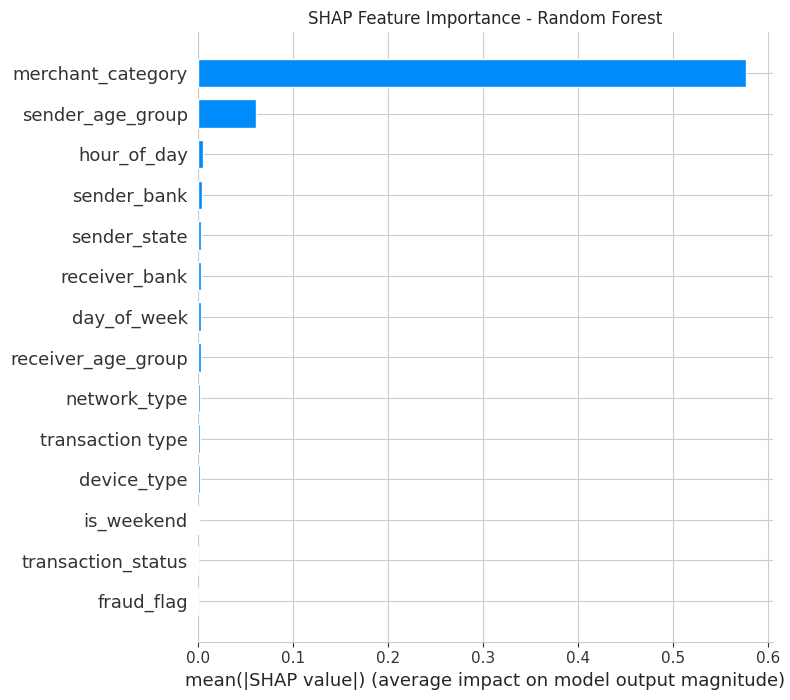


Generating SHAP Density Plot (Beeswarm)...


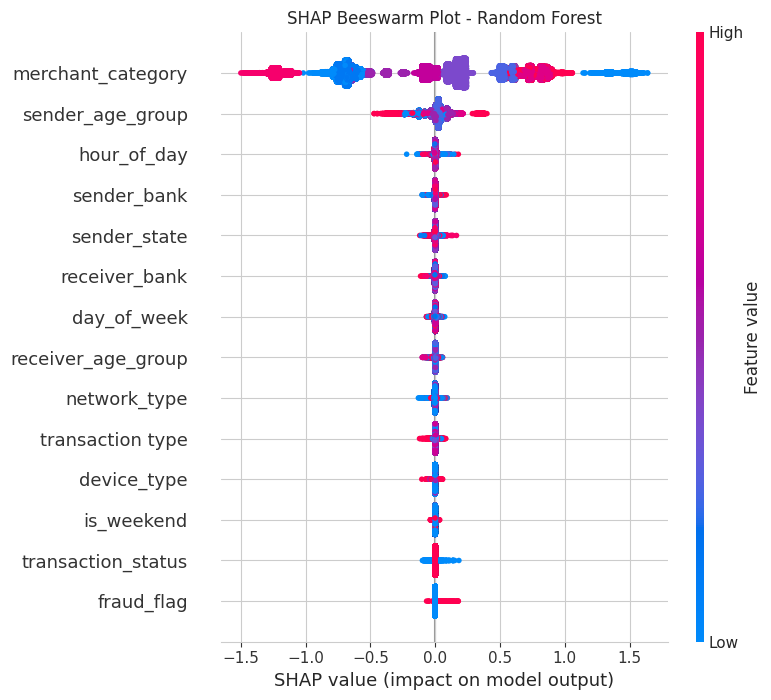


GENERATING ADVANCED VISUALS: Random Forest


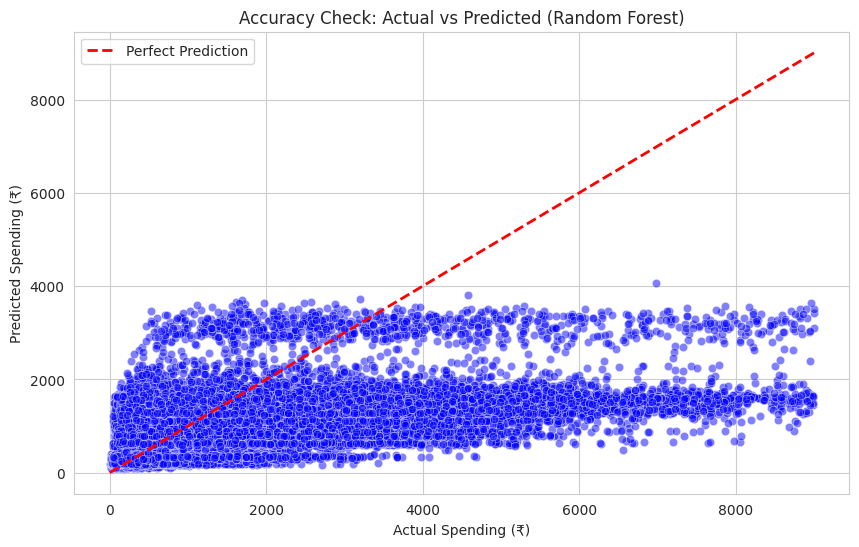

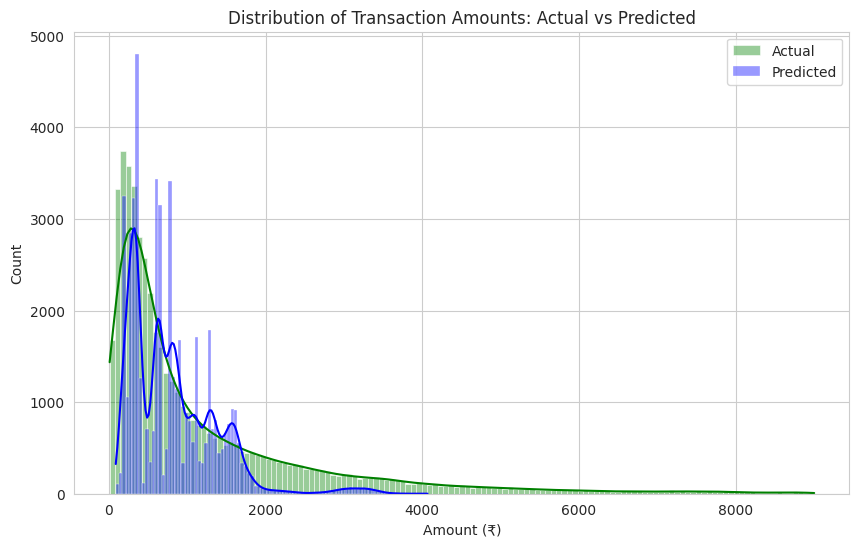

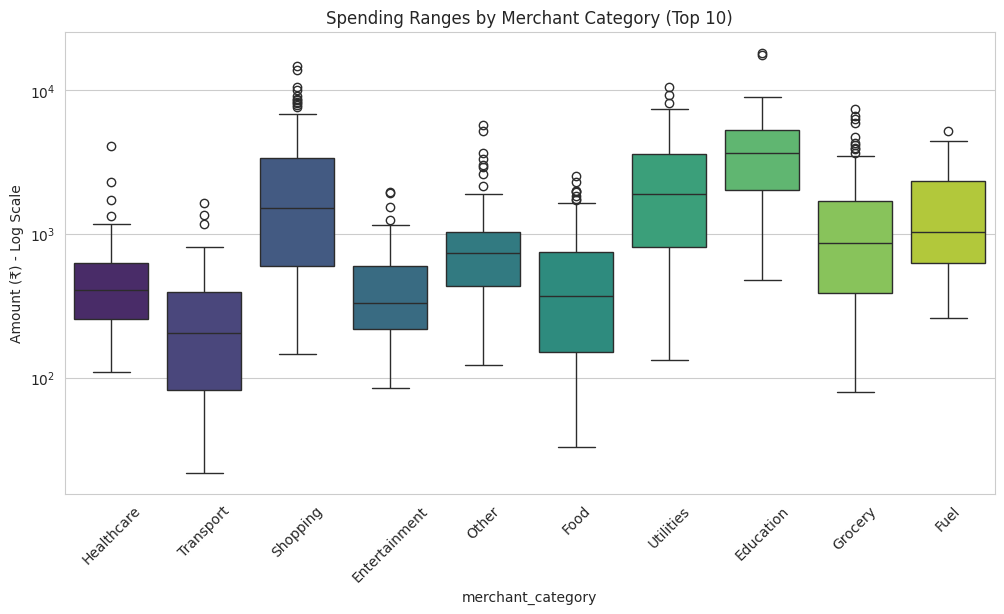


 SAVING MODEL FOR STREAMLIT APP
 Model Artifacts Saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
if __name__ == "__main__":
    main()